In [1]:
import csv
from collections import defaultdict
from collections import Counter
import baltic
import matplotlib.pyplot as plt
import geopandas as gpd
import tqdm
import numpy as np
import pandas as pd
import dendropy
import seaborn as sns
import scipy
import matplotlib.patches as mpatches
import matplotlib as mpl
import datetime as dt
from epiweeks import Week, Year

font = {'family' : 'Helvetica',
'weight' : 'bold',
'size' : 18}
mpl.rcParams.update({"svg.fonttype": 'none', 'text.usetex': False})

In [2]:
hex_codes = [
    "#618669",
    "#4E5E48",
    "#F1C081",
    "#C08A46",
    "#A83B17",
    "#862E19",
    "#62270C"
]

state_colours = {"NY_light":"#618669", "NY_dark":"#4E5E48", "New_York_light": "#618669", "New_York_dark": "#4E5E48",
                 "MA_light":"#F1C081", "MA_dark":"#C08A46", "Massachusetts_light":"#F1C081", "Massachusetts_dark":"#C08A46",
                "CT_light":"#A83B17", "CT_dark":"#862E19", "Connecticut_light":"#A83B17", "Connecticut_dark":"#862E19",
                "other":"#62270C", "Other":"#62270C",
                "New_York":"#618669", "Connecticut":"#a83c18", "Massachusetts": "#F1C081"}


col_pal = sns.color_palette(hex_codes)
col_pal

[(0.3803921568627451, 0.5254901960784314, 0.4117647058823529),
 (0.3058823529411765, 0.3686274509803922, 0.2823529411764706),
 (0.9450980392156862, 0.7529411764705882, 0.5058823529411764),
 (0.7529411764705882, 0.5411764705882353, 0.27450980392156865),
 (0.6588235294117647, 0.23137254901960785, 0.09019607843137255),
 (0.5254901960784314, 0.1803921568627451, 0.09803921568627451),
 (0.3843137254901961, 0.15294117647058825, 0.047058823529411764)]

In [3]:
tree = dendropy.Tree.get(path="../phylogenetic_data/new_introductions.tree", schema="nexus", preserve_underscores=True)

object_dict = {}
count_dict = {}
for nde in tree.preorder_node_iter():
    if not nde.taxon:
        count_dict[nde] = nde.annotations['node_count'].value
        object_dict[nde.annotations['node_count'].value] = nde
    else:
        object_dict[nde.taxon.label] = nde

In [4]:
clusters = defaultdict(list)
with open("../phylogenetic_data/introduction_times.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        clusters[l['node_number']] = l['tips'].split(";")

In [5]:
distances = {}
persistences = {}
for mrca, tips in clusters.items():
    if len(tips) >= 3:
        heights = {i: float(object_dict[i].annotations['height'].value) for i in tips}
        earliest = max(heights.items(), key=lambda x: x[1]) #which is max height
        latest = min(heights.items(), key=lambda x:x[1]) #min height in cluster
        distance = float(object_dict[mrca].annotations['height'].value) - earliest[1]
        persistence = float(object_dict[mrca].annotations['height'].value) - latest[1]
        distances[mrca] = distance
        persistences[mrca] = persistence

## distributions

In [7]:
print(len(clusters))
dist_list = list(distances.values())
print(f'Mean time from introduction to first sample = {np.mean(dist_list)}')
print(f'lower hpd = {np.percentile(dist_list, 2.5)}')
print(f'upper hpd = {np.percentile(dist_list, 97.5)}')
print(f'longest time = {max(distances.items(), key=lambda x: x[1])}')
print(f'shortest time = {min(distances.items(), key=lambda x: x[1])}')
print("\n")
pers_list = list(persistences.values())
print(f'Mean time from introudction to last sample = {np.mean(pers_list)}')
print(f'lower hpd = {np.percentile(pers_list, 2.5)}')
print(f'upper hpd = {np.percentile(pers_list, 97.5)}')
print(f'longest time = {max(persistences.items(), key=lambda x: x[1])}')
print(f'shortest time = {min(persistences.items(), key=lambda x: x[1])}')

##plot this as a distribution
## also plot persistence as a distribution

75
Mean time from introduction to first sample = 1.1683955642177644
lower hpd = 0.4595744084070954
upper hpd = 3.27358274608243
longest time = ('137', 3.97218790561237)
shortest time = ('193', 0.3789083906392925)


Mean time from first sample to last sample = 2.808149948019083
lower hpd = 0.647114883003632
upper hpd = 7.493046265681911
longest time = ('213', 8.610346497867923)
shortest time = ('78', 0.5271521012595072)


/Users/verityhill/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


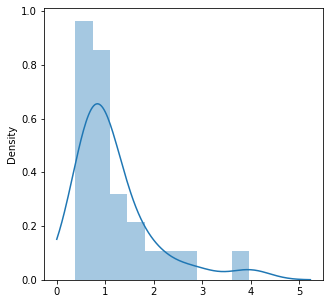

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.distplot(dist_list,ax=ax, kde_kws={'clip': (0.0, 6.0)})

plt.savefig("../../figures/figure_3/surv_gap_distribution.png", bbox_inches='tight')
plt.savefig("../../figures/figure_3/surv_gap_distribution.pdf", bbox_inches='tight')


plt.show()

/Users/verityhill/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


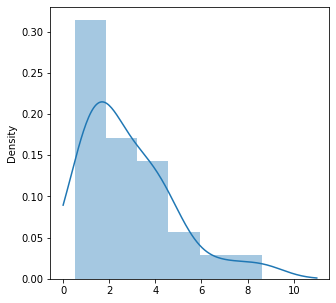

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.distplot(pers_list,ax=ax,  kde_kws={'clip': (0.0, 11.0)})


plt.show()

## over time

In [3]:
location_dict = {}
with open("../phylogenetic_data/location_outbreaks.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        location_dict[l['mrca']] = l['locations'].split(";")

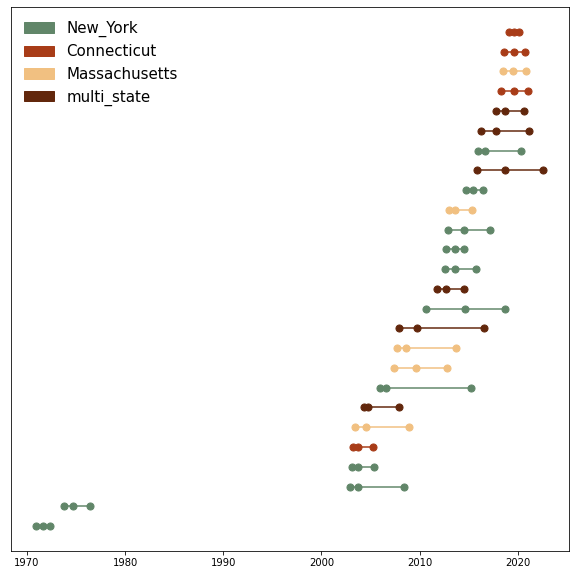

In [9]:
fig, ax = plt.subplots(1,1, figsize = (10,10))

mrt = 2019.79
y = 0
pal = {}

sorted_distances = {k: v for k, v in sorted(distances.items(), key=lambda item: float(object_dict[item[0]].annotations['height'].value), reverse=True)}
for mrca, distance in sorted_distances.items():
    y += 2
    
    node_height = float(object_dict[mrca].annotations['height'].value)
    tip_height = node_height - distance
    last_tip_height = tip_height - persistences[mrca]
    
    tip_date = mrt - tip_height
    node_date = mrt - node_height
    last_tip_date = mrt - last_tip_height
    
    
    locations = location_dict[mrca]
    if len(locations) == 1:
        pal[locations[0]] = state_colours[locations[0]]
        colour = state_colours[locations[0]]
    else:
        colour = "#62270C"
        pal["multi_state"] = colour
        
    ax.scatter(tip_date, y, color = colour, s=50)
    ax.scatter(node_date, y, color = colour, s=50)
    ax.scatter(last_tip_date, y, color = colour, s=50)
    
    ax.plot([node_date,tip_date], [y,y], color=colour, zorder=0)
    ax.plot([tip_date,last_tip_date], [y,y], color=colour, zorder=0)
    
patch_list = []

for group, code in pal.items():
    patch_list.append(mpatches.Patch(color=code, label=group))
ax.legend(handles=patch_list, loc="upper left",fontsize=15,frameon=False)

    
ax.set_yticks([])

plt.show()

## 2019 clusters

In [6]:
mrt = 2019.79

In [7]:
only_2019 = defaultdict(list)
include_2019 = defaultdict(list)
all_2019s = defaultdict(list)

for k,v in clusters.items():
    for seq in v:
        year = seq.split("|")[1].split("-")[0]
        if year == "2019":
            all_2019s[k] = v
            
for k,v in all_2019s.items():
    only_2019_bool = True
    for seq in v:
        year = seq.split("|")[1].split("-")[0]
        if year != "2019":
            include_2019[k] = v
            only_2019_bool = False
    if only_2019_bool:
        only_2019[k] = v
            

In [11]:
print(len(all_2019s))
print(len(only_2019))
print(len(include_2019))

20
16
4


In [12]:
count_singletons = 0
count_cluster = 0
for i, v in only_2019.items():
    if len(v) == 1:
        count_singletons += 1
    elif len(v) >= 3:
        count_cluster +=1 
        
print((count_singletons))
print((count_cluster))

9
4


In [20]:
print(len(include_2019)

4


In [21]:
for k,v in include_2019.items():
    print(k,v)

162 ['13866-19_S73_2019|2019-09-17', '18VX3174_S43_2018|2018-11-01', '18VX2715_S44_2018|2018-09-19', 'SL18-1204_S28_2018|2018-09-26']
174 ['16370365_S13_2016|2016-08-17', 'RAB19ANI04511_S25_2019|2019-08-13', 'ARB18MS330453_S21_2018|2018-08-07', 'ARB18MS330394_S19_2018|2018-07-31', 'ARB17MS330746_S18_2017|2017-09-26', 'ARB18MS370301_S20_2018|2018-07-30', 'ARB17MS370250_S26_2017|2017-07-26', 'ARB17MS260236_S17_2017|2017-09-19']
386 ['18341-18_S51_2018|2018-09-26', '13966-17_S46_2017|2017-10-05', '19350-18_S53_2018|2018-10-09', 'SL19-1516_S33_2019|2019-08-25', '17667-18_S50_2018|2018-09-19', '18694-18_S52_2018|2018-10-01', '14098-17_S47_2017|2017-10-11']
394 ['14759-19_S80_2019|2019-09-30', '19VX2817_S42_2019|2019-08-28', '10229-19-19_S57_2019|2019-08-19', '14275-19_S74_2019|2019-09-23', '12004-19_S68_2019|2019-08-29', 'SL19-1219_S41_2019|2019-08-07', 'NM19-0698_S39_2019|2019-09-23', '9180-19_S55_2019|2019-08-08', 'ARB18MS350318_S22_2018|2018-09-20', 'SL18-1166_S27_2018|2018-09-17']


In [15]:
intro_2019 = []
distance_2019 = []
persistence_2019 = []
larger_intro = []
for k,v in all_2019s.items():
    if len(v) >=3:
        distance_2019.append(distances[k])
        persistence_2019.append(persistences[k])
        larger_intro.append(mrt - float(object_dict[k].annotations['height'].value))
    
    intro_2019.append(mrt - float(object_dict[k].annotations['height'].value))
    

In [21]:
print(np.mean(intro_2019)) #including singletons
print(max(larger_intro))
print(min(larger_intro))
print(np.mean(larger_intro))


2018.7539977111733
2019.1258615973704
2015.8533885688134
2017.549079114473


In [19]:
print(np.percentile(larger_intro, 2.5))
print(np.percentile(larger_intro, 97.5))

2015.8702010388174
2019.0405287909637


In [37]:
for k,v in all_2019s.items():
    intro = (mrt - float(object_dict[k].annotations['height'].value))
    if intro >= 2019:
        if len(v) == 1:
            print(f"singleton {intro}")
        else:
            print(f"multi {intro}")

singleton 2019.576301369863
singleton 2019.6557534246574
multi 2019.1258615973704
singleton 2019.79
multi 2019.5603007017567
singleton 2019.6749315068491
singleton 2019.6502739726027
multi 2019.4465512470158
singleton 2019.6557534246574
singleton 2019.6475342465753
singleton 2019.7269863013698
singleton 2019.5543835616438


In [52]:
non_2019_distances = []
non_2019_persistences = []
for k,v in distances.items():
    if k not in all_2019s.keys():
        non_2019_distances.append(v)
        non_2019_persistences.append(persistences[k])

In [50]:
# print(np.mean(distance_2019))
# print(np.percentile(distance_2019, 97.5))
# print(np.percentile(distance_2019, 2.5))
print(np.mean(non_2019_distances))
print(np.percentile(non_2019_distances, 97.5))
print(np.percentile(non_2019_distances, 2.5))

1.143258843492824
3.2165778160722858
0.4451631858118484


In [53]:
print(np.mean(persistence_2019))
print(np.percentile(persistence_2019, 97.5))
print(np.percentile(persistence_2019, 2.5))
print(np.mean(non_2019_persistences))
print(np.percentile(non_2019_persistences, 97.5))
print(np.percentile(non_2019_persistences, 2.5))

2.1494825293625537
3.890036088720774
0.5271521012595072
3.10089102297754
7.850582339981433
0.8294892174619544
